In [574]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [575]:
train = pd.read_csv('../datasets/jinnan/jinnan_round1_train_20181227-1.csv', encoding = 'gb18030')
test  = pd.read_csv('../datasets/jinnan/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [576]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 44 columns):
样本id    1396 non-null object
A1      1396 non-null int64
A2      42 non-null float64
A3      1354 non-null float64
A4      1396 non-null int64
A5      1396 non-null object
A6      1396 non-null float64
A7      149 non-null object
A8      149 non-null float64
A9      1396 non-null object
A10     1396 non-null int64
A11     1396 non-null object
A12     1396 non-null int64
A13     1396 non-null float64
A14     1396 non-null object
A15     1396 non-null float64
A16     1396 non-null object
A17     1396 non-null float64
A18     1396 non-null float64
A19     1396 non-null int64
A20     1396 non-null object
A21     1393 non-null float64
A22     1396 non-null float64
A23     1393 non-null float64
A24     1395 non-null object
A25     1396 non-null object
A26     1394 non-null object
A27     1396 non-null int64
A28     1396 non-null object
B1      1396 non-null int64
B2      1396 non-null f

In [577]:
train.describe()

,A1,A2,A3,A4,A6,A8,A10,A12,A13,A15,A17,A18,A19,A21,A22,A23,A27,B1,B2,B3,B6,B8,B12,B13,B14,收率
count,1396.000000,42.0,1354.000000,1396.000000,1396.000000,149.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1393.000000,1396.000000,1393.000000,1396.000000,1396.000000,1396.000000,1396.000000,1396.000000,1395.000000,1395.000000,1395.000000,1396.000000,1396.000000
mean,298.853868,125.0,403.515510,705.974212,28.287751,78.818792,100.861032,102.641834,0.199907,103.829370,104.766905,0.199928,231.067335,48.707825,9.117120,5.002872,74.396848,334.468481,3.454477,3.500072,72.065186,43.709677,1020.215054,0.149419,410.403295,0.923244
std,10.130552,0.0,13.348093,53.214754,6.742765,2.683920,0.905198,0.915387,0.002524,0.963639,1.401446,0.002676,50.478071,4.976531,0.369152,0.136638,3.044490,104.406050,0.388310,0.002676,9.161986,4.338396,205.920155,0.008213,26.018410,0.030880
min,200.000000,125.0,270.000000,470.000000,17.000000,70.000000,100.000000,98.000000,0.120000,100.000000,89.000000,0.100000,100.000000,20.000000,3.500000,4.000000,45.000000,190.000000,0.150000,3.500000,40.000000,20.000000,400.000000,0.030000,40.000000,0.624000
25%,300.000000,125.0,405.000000,700.000000,24.000000,80.000000,100.000000,102.000000,0.200000,103.000000,104.000000,0.200000,200.000000,50.000000,9.000000,5.000000,73.000000,320.000000,3.500000,3.500000,65.000000,45.000000,800.000000,0.150000,400.000000,0.902000
50%,300.000000,125.0,405.000000,700.000000,29.000000,80.000000,101.000000,103.000000,0.200000,104.000000,105.000000,0.200000,200.000000,50.000000,9.000000,5.000000,73.000000,320.000000,3.500000,3.500000,78.000000,45.000000,1200.000000,0.150000,400.000000,0.925000
75%,300.000000,125.0,405.000000,700.000000,30.000000,80.000000,102.000000,103.000000,0.200000,104.000000,105.000000,0.200000,300.000000,50.000000,9.000000,5.000000,77.000000,330.000000,3.500000,3.500000,80.000000,45.000000,1200.000000,0.150000,420.000000,0.943000
max,300.000000,125.0,405.000000,980.000000,97.000000,82.000000,103.000000,107.000000,0.200000,109.000000,108.000000,0.200000,350.000000,90.000000,10.000000,10.000000,80.000000,1200.000000,3.600000,3.600000,80.000000,73.000000,1200.000000,0.150000,460.000000,1.000800


基本数据分析

In [578]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
26,A26,88,0.143266,18.982808,object
36,B8,25,0.071633,77.722063,float64


In [579]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


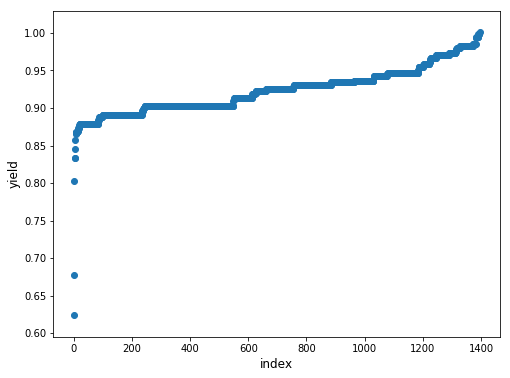

In [580]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

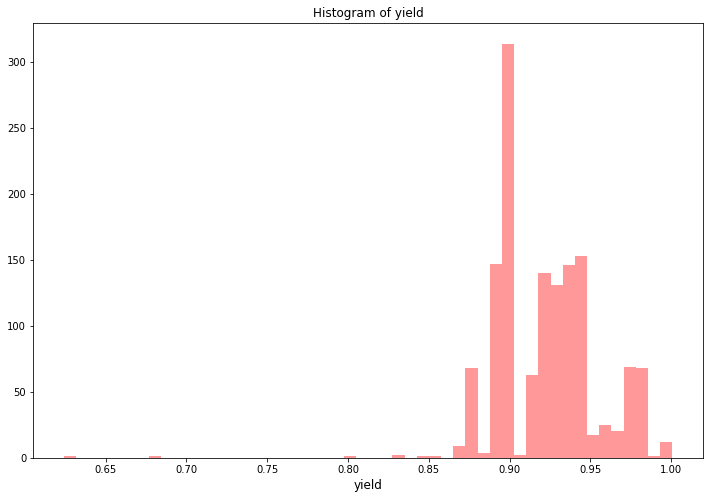

In [581]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [582]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [583]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 暂时不删除，后面构造特征需要
good_cols.append('A4')

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9856733524355301


In [584]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [585]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [586]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [587]:
# 催化剂的浓度
data['b14/a4_a19_a21_a22_b1_b12'] = data['B14']/(data['A4']+data['A19']+data['A21']+data['A22']+data['B1']+data['B12']+data['B14'])
# data['b12/a4_a19_a21_a22_b1'] = data['B12']/(data['A4']+data['A19']+data['A21']+data['A22']+data['B1']+data['B12'])
# data['b1/a4_a19_a21_a22'] = data['B1']/(data['A4']+data['A19']+data['A21']+data['A22']+data['B1'])
# data['a21_a22/a4_a19'] = (data['A21']+data['A22'])/(data['A4']+data['A19']+data['A21']+data['A22'])
# data['a19/a4'] = data['A19']/(data['A4']+data['A19'])

numerical_columns.append('b14/a4_a19_a21_a22_b1_b12')
# numerical_columns.append('b12/a4_a19_a21_a22_b1')
# numerical_columns.append('b1/a4_a19_a21_a22')
# numerical_columns.append('a21_a22/a4_a19')
# numerical_columns.append('a19/a4')

del data['A4']
categorical_columns.remove('A4')
data.columns

Index(['样本id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', 'b14/a4_a19_a21_a22_b1_b12'],
      dtype='object')

In [588]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(1381, 34)
(150, 34)


添加新特征，将收率进行分箱，然后构造每个特征中的类别对应不同收率的均值

In [589]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 6, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0','intTarget_5.0']
mean_columns = []

for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)


train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1381, 124)
(150, 124)


In [590]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    
    return  score/2

In [591]:
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.0000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols

In [592]:
# best_features = featureSelect(train.columns.tolist())
# print(best_features)

X_train = train[mean_columns+numerical_columns].values
X_test = test[mean_columns+numerical_columns].fillna(0).values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 1260)
(150, 1260)


In [593]:
y_train = target.values

训练模型

In [594]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

# max_depth < 0 模型深度没限制

folds = KFold(n_splits=6, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000213028	valid_1's l2: 0.00023346
[400]	training's l2: 0.000139855	valid_1's l2: 0.000159986
[600]	training's l2: 0.000113944	valid_1's l2: 0.000136801
[800]	training's l2: 0.00010339	valid_1's l2: 0.000128794
[1000]	training's l2: 9.78691e-05	valid_1's l2: 0.000125413
[1200]	training's l2: 9.42577e-05	valid_1's l2: 0.000123144
[1400]	training's l2: 9.16196e-05	valid_1's l2: 0.000121707
[1600]	training's l2: 8.9649e-05	valid_1's l2: 0.000120889
[1800]	training's l2: 8.79144e-05	valid_1's l2: 0.000120043
[2000]	training's l2: 8.65447e-05	valid_1's l2: 0.000119689
[2200]	training's l2: 8.53362e-05	valid_1's l2: 0.000119266
[2400]	training's l2: 8.42968e-05	valid_1's l2: 0.000118849
[2600]	training's l2: 8.3326e-05	valid_1's l2: 0.000118568
Early stopping, best iteration is:
[2680]	training's l2: 8.29964e-05	valid_1's l2: 0.00011839
fold n°2
Training until validation scores don't improve for 10

In [595]:
##### xgb
xgb_params = {'eta': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}

# reg:linear 线性回归；reg:logistic 逻辑回归

folds = KFold(n_splits=6, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.421058	valid_data-rmse:0.420683
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.155494	valid_data-rmse:0.15515
[200]	train-rmse:0.058683	valid_data-rmse:0.058926
[300]	train-rmse:0.023766	valid_data-rmse:0.024878
[400]	train-rmse:0.01149	valid_data-rmse:0.014215
[500]	train-rmse:0.007499	valid_data-rmse:0.011749
[600]	train-rmse:0.006177	valid_data-rmse:0.011293
[700]	train-rmse:0.005532	valid_data-rmse:0.011196
[800]	train-rmse:0.005029	valid_data-rmse:0.011179
[900]	train-rmse:0.00462	valid_data-rmse:0.011179
[1000]	train-rmse:0.004284	valid_data-rmse:0.011173
Stopping. Best iteration:
[822]	train-rmse:0.004937	valid_data-rmse:0.011166

fold n°2
[0]	train-rmse:0.421387	valid_data-rmse:0.419022
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved i

In [596]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb, oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=6, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = GradientBoostingRegressor(n_estimators=90, learning_rate=0.08, max_depth=2, random_state=0, loss='ls')
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 12
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10
fold 11


0.00011254471318199566

In [597]:
sub_df = pd.read_csv('../datasets/jinnan/jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("../datasets/jinnan/results.csv", index=False, header=None)